In [118]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize Class, Calculate datavector and cov matrices

No Shotnoise, No Finger of God term

In [119]:
"""
 b = galaxy bias
 f = structure growth rate
 s = velocity dispersion in FoG term 
 nn = shot noise 
"""
cosmo = class_covariance(KMIN=0.001, KMAX = 100, n=5000, n_y=200, RMIN = 0.001, RMAX = 200, n2 = 101, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin', smooth_filter=True)

#cosmo.compile_fortran_modules()

# copy class to keep initial setting
cosmo2 = cosmo
cosmo2.MatterPower()

# calling matter power spectrum from camb
cosmo.MatterPower()
p_model = cosmo.multipole_P(0)
xi_model = cosmo.multipole_Xi(0)

# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)     # cov P monopole
covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model
covpxi_model_old = cosmo.covariance_PXi_old(0,0)
covtot_model = np.vstack(( np.hstack((covp_model, covpxi_model )), \
                          np.hstack((covpxi_model.T, covxi_model )) ))   # cov_combined
dpdb,_,_ = cosmo.derivative_P_bfs(0)      # dp/db
dxdb,_,_ = cosmo.derivative_bfs(0)        # dxi/db
dpxdb = np.hstack([dpdb, dxdb])

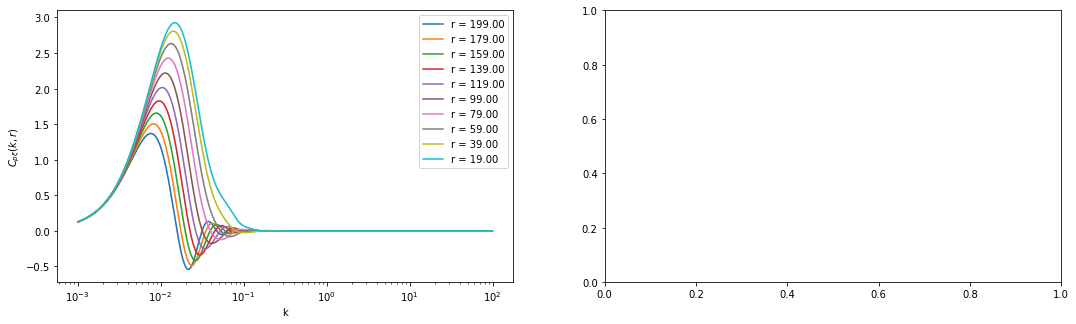

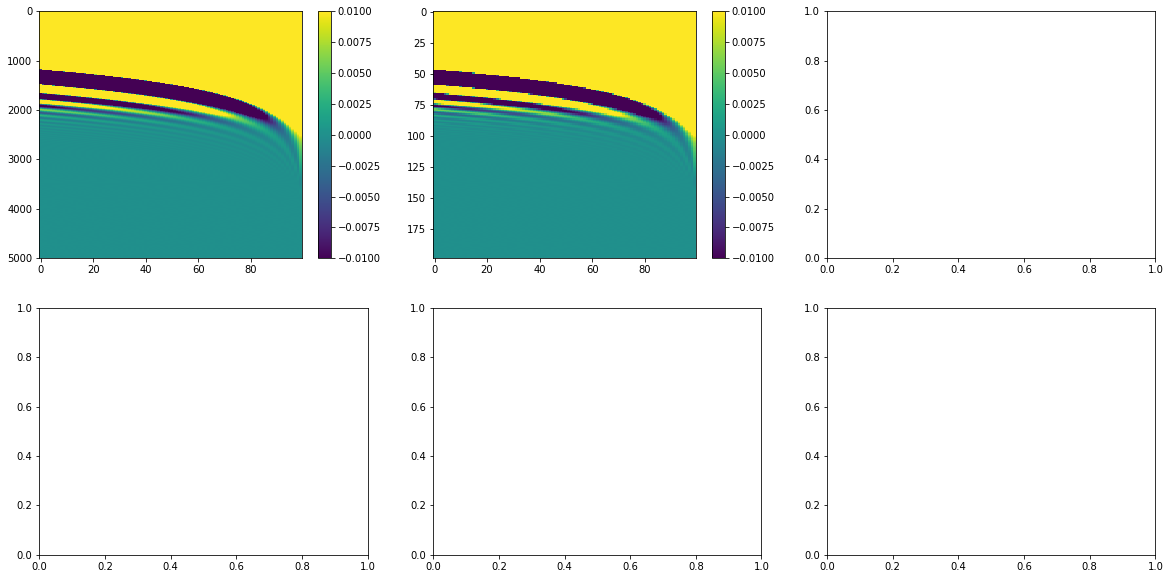

In [125]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,5))

kcenter = cosmo.kbin

#fig, ax = plt.subplots()
for i in np.arange(0, cosmo.rcenter.size, 10):
    ax.plot(cosmo.kbin, covpxi_model_old[:,i], alpha = 0.2)
    ax.plot(cosmo.kcenter_y, covpxi_model[:,i], label='r = {:0.2f}'.format(cosmo.rcenter[i]), color = ax.lines[-1].get_color())
    
#ax3.set_ylim(-.05, .05)
#ax3.set_xlim(1e-01,1.0)
ax.set_xlabel('k')
ax.set_ylabel(r'$C_{p\xi}(k,r)$')
ax.set_xscale('log')
ax.legend(loc='best')


fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (20,10))

im3 = ax1.imshow(covpxi_model_old, aspect='auto', vmax=0.01, vmin=-0.01)
im6 = ax2.imshow(covpxi_model, aspect='auto', vmax=0.01, vmin=-0.01)
fig.colorbar(im3,ax=ax1)
fig.colorbar(im6,ax=ax2)

### Theory Datavector with varying bias

#### 2D Interpolation 

In [68]:
def masking_datav_cov( cosmo, cov = None, datavs = None, 
                     p=False, kmin=None, kmax = None, rmin = None, rmax = None, pxi=False):
    
    
    if kmin == None : 
        idx_kmin = 0
        idx_kmax = cosmo.kbin_y.size
    else : 
        idx_kmin = get_closest_index_in_data( kmin, cosmo.kbin_y )   
        idx_kmax = get_closest_index_in_data( kmax, cosmo.kbin_y )
    
    if rmin == None : 
        idx_rmin = cosmo.rmax.size
        idx_rmax = 0
    else : 
        idx_rmin = get_closest_index_in_data( rmin, cosmo.rmin )   
        idx_rmax = get_closest_index_in_data( rmax, cosmo.rmax )
       
    
    if pxi: 
    
        print 'kmin', idx_kmin, ' kmax', idx_kmax, ' rmin', idx_rmin, ' rmax', idx_rmax
        covpxi = cov[idx_kmin:idx_kmax+1,\
            idx_rmax:idx_rmin+1]
        print covpxi.shape
        return covpxi
    
    mask = np.zeros(cov.shape[0], dtype=bool)
    if p : mask[idx_kmin:idx_kmax+1] = 1
    else : mask[idx_rmax:idx_rmin+1] = 1
        
    Nk = np.sum(mask)
    m1, m2 = np.mgrid[0:cov.shape[0],0:cov.shape[0]]
    mask_2d = mask[m1] * mask[m2]
           
    if p :print 'Nk ', Nk, ' kmin', idx_kmin, ' kmax', idx_kmax
    else : print 'Nr ', Nk, ' rmin', idx_rmin, ' rmax', idx_rmax
    
    #covinv = np.linalg.inv(cov[mask_2d].reshape(Nk,Nk))
    cov = cov[mask_2d].reshape(Nk,Nk)
    dqdb = datavs[mask]
    
    return cov, dqdb
    #sigma_theory = 1./np.sqrt(np.dot( np.dot( dqdb, covinv), dqdb.T))
    #print ' theory :', sigma_theory
    #return sigma_theory

In [45]:
from numpy.linalg import inv

## Calcuate Bestfit Bias 

Setting k range and r range

In [155]:
kmin = 0.01
kmax = 0.2
rmin = 10
rmax = 200

In [156]:
dpdb.shape, dxdb.shape, dpxdb.shape

((199,), (100,), (299,))

In [157]:
sigma_p = getting_sigma_bs_theory( cosmo, cov = covp_model, datavs=dpdb, p=True, kmin=kmin, kmax=kmax )
sigma_x = getting_sigma_bs_theory( cosmo, cov = covxi_model, datavs=dxdb, rmin = rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo, cov = covtot_model, datavs = dpxdb,
                                     kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)
sigma_d = getting_sigma_bs_diff_theory( cosmo, covp = covp_model, covxi = covxi_model,datavsp=dpdb, datavsxi=dxdb,
                                        kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

Nk  53  kmin 40  kmax 92
 theory : 0.002516906612379804
Nr  95  rmin 94  rmax 0
 theory : 0.003896464559407355
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0017551271064707647
Nk  53  kmin 40  kmax 92
Nr  95  rmin 94  rmax 0
 theory : 0.0021141918738840576
---------------------------------
 Error on bias (Theory) 
 sigma_p      : 0.00251690661238 
 sigma_xi     : 0.00389646455941 
 sigma_combin : 0.00175512710647 
 sigma_diff   : 0.00211419187388 
---------------------------------


In [158]:
covp_cut, dpdb_cut = masking_datav_cov( cosmo, cov = covp_model, datavs = dpdb, 
                   p=True, kmin=kmin, kmax = kmax)

covxi_cut, dxdb_cut = masking_datav_cov( cosmo, cov = covxi_model, datavs = dxdb, 
                   p=False, rmin=rmin, rmax = rmax)

covpxi_cut = masking_datav_cov( cosmo, cov = covpxi_model,
                   pxi=True, kmin=kmin, kmax = kmax, rmin=rmin, rmax = rmax)

Nk  53  kmin 40  kmax 92
Nr  95  rmin 94  rmax 0
kmin 40  kmax 92  rmin 94  rmax 0
(53, 95)


In [159]:
def second_order_t(epsilon, dpdb_cut, dxdb_cut, covp_cut, covpxi_cut, covxi_cut):
    value = - 2 * epsilon * \
    np.dot(np.dot(np.dot( np.dot( dpdb_cut, inv(covp_cut)), covpxi_cut ), \
                  inv(covxi_cut) ), dxdb_cut )
    return value

In [160]:
#ep = np.logspace(np.log10(0.001), np.log10(1.0), 10)
ep = np.linspace(0.0, 1, 30)
soarray = np.zeros(ep.size)
sig_difference = np.zeros(ep.size)

sigma_d = getting_sigma_bs_diff_theory( cosmo, covp = covp_model, covxi = covxi_model,datavsp=dpdb, datavsxi=dxdb,
                                    kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )  
for i, e in enumerate(ep):
    soarray[i] = second_order_t(e, dpdb_cut, dxdb_cut, covp_cut, covpxi_cut, covxi_cut)    
    covtot_e = np.vstack(( np.hstack((covp_model, e * covpxi_model )), \
                          np.hstack(( e * covpxi_model.T, covxi_model )) )) 
    
    sigma_c = getting_sigma_bs_com_theory( cosmo, cov = covtot_e, datavs = dpxdb,
                                     kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)
    sig_difference[i]=sigma_c**(-2) - sigma_d**(-2)

Nk  53  kmin 40  kmax 92
Nr  95  rmin 94  rmax 0
 theory : 0.0021141918738840576
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.002114191873884057
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0021410305272826203
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0021668460575209464
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0021916273220770875
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0022153563591765213
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0022380077843921486
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0022595479967649768
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0022799341568590526
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0022991128861280757
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.0023170186197215017
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.002333571521586949
N  148  kmin 40  kmax 92  rmin 94  rmax 0
 theory : 0.002348674838790287
N  148  kmin 40  kmax 92  rmin 94 

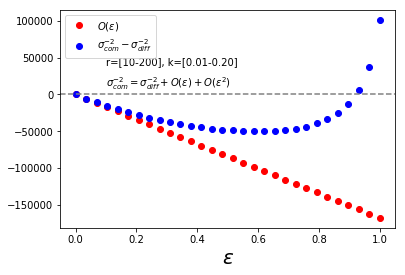

In [168]:
    
fig, ax = plt.subplots()
ax.plot(ep, soarray, 'ro', label=r'$O(\epsilon)$')
#ax.plot(ep, sig_difference, 'bo', label=r'$O(\epsilon)+ O(\epsilon^2)$')
ax.plot(ep, sig_difference, 'bo', label=r'$\sigma_{com}^{-2} - \sigma_{diff}^{-2}$')

equation = r'$\sigma_{com}^{-2} = \sigma_{diff}^{-2} + O(\epsilon) + O(\epsilon^2)$'
rkrange = 'r=[{:0.0f}-{:0.0f}], k=[{:0.2f}-{:0.2f}]'.format(rmin, rmax, kmin, kmax)
ax.axhline(y=0, color='grey', ls = '--')
ax.text(0.1, 10000, equation)
ax.text(0.1, 40000, rkrange)
ax.legend()
ax.set_xlabel('$\epsilon$', fontsize = 20)

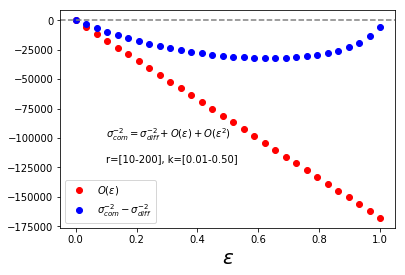

In [154]:
    
fig, ax = plt.subplots()
ax.plot(ep, soarray, 'ro', label=r'$O(\epsilon)$')
ax.plot(ep, sig_difference, 'bo', label=r'$\sigma_{com}^{-2} - \sigma_{diff}^{-2}$')

equation = r'$\sigma_{com}^{-2} = \sigma_{diff}^{-2} + O(\epsilon) + O(\epsilon^2)$'
rkrange = 'r=[{:0.0f}-{:0.0f}], k=[{:0.2f}-{:0.2f}]'.format(rmin, rmax, kmin, kmax)

ax.axhline(y=0, color='grey', ls = '--')
ax.text(0.1, -100000, equation)
ax.text(0.1, -120000, rkrange)
ax.legend()

ax.set_xlabel('$\epsilon$', fontsize = 20)

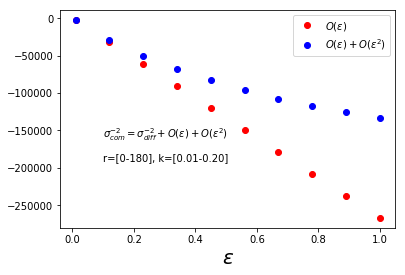

In [218]:
    
fig, ax = plt.subplots()
ax.plot(ep, soarray, 'ro', label=r'$O(\epsilon)$')
ax.plot(ep, sig_difference, 'bo', label=r'$O(\epsilon)+ O(\epsilon^2)$')

equation = r'$\sigma_{com}^{-2} = \sigma_{diff}^{-2} + O(\epsilon) + O(\epsilon^2)$'
rkrange = 'r=[{:0.0f}-{:0.0f}], k=[{:0.2f}-{:0.2f}]'.format(rmin, rmax, kmin, kmax)

ax.text(0.1, -160000, equation)
ax.text(0.1, -190000, rkrange)
ax.legend()
ax.set_xlabel('$\epsilon$', fontsize = 20)

In [39]:
second_ot = second_order_t(epsilon, dpdb_cut, dxdb_cut, covp_cut, covpxi_cut, covxi_cut)

In [43]:
sigma_d**(-2)+second_ot

10362.681889383877

In [44]:
sigma_c**(-2)

10382.052009115436

In [10]:
covpxi_cut.shape, covxi_cut.shape, covp_cut.shape

((601, 80), (80, 80), (601, 601))

#### Theoretical calculation 

#### Chi2 distribution test

In [ ]:
chibin = np.linspace(0.5, 1.5, 50)
fig, ax = plt.subplots()
#ax.plot( np.arange(len(chi2p) ), chi2p)
ax.hist(chi2p, bins = chibin, label='p', histtype='step');
ax.hist(chi2x, bins = chibin, label ='xi', histtype='step');
ax.hist(chi2_diff, bins = chibin, label='diff', histtype='step');
ax.hist(chi2_com, bins = chibin, label='combin', histtype='step');
ax.set_xlabel('chi2')
ax.legend()

In [48]:
print '* with SHOT Noise'

# print out results-------------------------------
print '---------------------------------\
\n#1 Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

# print out results-------------------------------
sigma_pm, sigma_xm, sigma_cm, sigma_dm \
= np.std(bestfit_b_p), np.std(bestfit_b_xi), np.std(bestfit_b_com), np.std(bestfit_b_diff)
print '---------------------------------\
\n#2 Error on bias (Mock) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n'.format(sigma_pm, sigma_xm, sigma_cm, sigma_dm)

# print out results-------------------------------
sigma_cm2, sigma_dm2 = np.std(bestfit_b_com2[0]), np.std(bestfit_b_diff2[0])
print ' (Uncorrelated Mock) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_cm2, sigma_dm2)

print '---------------------------------\n\
#3 Error on bias \n \
(Mock, cross bias is obtained \n from bestfit bias of P and Xi)\n'
combine_sigmab(bestfit_b_p, bestfit_b_xi)

* with SHOT Noise
---------------------------------
#1 Error on bias (Theory) 
 sigma_p      : 0.0063797266121 
 sigma_xi     : 0.00899008324001 
 sigma_combin : 0.00262687042688 
 sigma_diff   : 0.0052028034416 
---------------------------------
---------------------------------
#2 Error on bias (Mock) 
 sigma_p      : 0.00642056635073 
 sigma_xi     : 0.00917669041399 
 sigma_combin : 0.00262308349839 
 sigma_diff   : 0.00687456732089 

 (Uncorrelated Mock) 
 sigma_combin : 0.461586799763 
 sigma_diff   : 0.00464687209723 
---------------------------------
---------------------------------
#3 Error on bias 
 (Mock, cross bias is obtained 
 from bestfit bias of P and Xi)

cov matrix = 
 |0.0000412237   0.0000436698| 
 |0.0000436698   0.0000842116|

sigma_p       : 0.006420566350733192
sigma_xi      : 0.009176690413987283
sigma_combin  : 0.006408322976568798
sigma_diff    : 0.005260772232375363


-------------------

==========

In [23]:
def mock_covariance_xib(xi_model, xi_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, xi_model.size ))
    for i in range(len(xi_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        x = xi_mock[i]
        mock_covbxi += ( b - b_model) * (x - xi_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi


def mock_covariance_pb(p_model, p_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, p_model.size ))
    for i in range(len(p_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        p = p_mock[i]
        mock_covbxi += ( b - b_model) * (p - p_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi

In [24]:
#kmin = 0.001
#kmax = 0.06
#rmin = 20
#rmax = 200

idx_kmin = get_closest_index_in_data( kmin, cosmo.kbin )   
idx_kmax = get_closest_index_in_data( kmax, cosmo.kbin )

idx_rmin = get_closest_index_in_data( rmin, cosmo.rmin )   
idx_rmax = get_closest_index_in_data( rmax, cosmo.rmax )

rbin = cosmo.rcenter[idx_rmax:idx_rmin]
kbin = cosmo.kcenter[idx_kmin:idx_kmax]

sigma_d = getting_sigma_bs_diff_theory( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_c, sigma_d)

Nk  1068  kmin 0  kmax 1067
Nr  90  rmin 89  rmax 0
 theory : 0.007393552229134158
N  1158  kmin 0  kmax 1067  rmin 89  rmax 0
 theory : 0.0032654014604566114
---------------------------------
 Error on bias (Theory) 
 sigma_combin : 0.00326540146046 
 sigma_diff   : 0.00739355222913 
---------------------------------


In [25]:
Fpp = np.linalg.inv(covp_model[idx_kmin:idx_kmax, idx_kmin:idx_kmax])
Fpb = np.dot(Fpp, dpdb[idx_kmin:idx_kmax])
Cxib = np.dot( covpxi_model[idx_kmin:idx_kmax,idx_rmax:idx_rmin].T, Fpb )  
final = np.dot( np.linalg.inv(covxi_model[idx_rmax:idx_rmin, idx_rmax:idx_rmin]), Cxib)
#mock_covbxi = mock_covariance_xib(xi_model, xi_mock, bestfit_b_p, 2.0)
#final_mock = np.dot(mock_covbxi[:,idx_rmax:idx_rmin], np.linalg.inv(mock_covxi[idx_rmax:idx_rmin, idx_rmax:idx_rmin]) )


In [26]:
#bestfit_b_p, chi2p = getting_sigma_bs( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
#                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
#bestfit_b_xi, chi2x = getting_sigma_bs( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
#                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
#sigma_pm = np.std(bestfit_b_p)
#sigma_xm = np.std(bestfit_b_xi)

In [27]:
covdiag = covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal()
DAT = np.column_stack((rbin, Cxib, covdiag, final))
header = 'rbin, cxib, cxi_diag, final, final_mock \n# kmin {} kmax {} rmin {} rmax{}'.format(kmin, kmax, rmin, rmax)
filename = '../data_txt/chris/cov_test_k{:0.2f}_{:0.2f}.txt'.format(kmin, kmax)
np.savetxt(filename, DAT, header=header)

In [28]:
#Fxi = np.linalg.inv(covxi_model[idx_rmax:idx_rmin, idx_rmax:idx_rmin])
#Fxib = np.dot(Fxi, dxdb[idx_rmax:idx_rmin])
#Cpb = np.dot( covpxi_model[idx_kmin:idx_kmax,idx_rmax:idx_rmin], Fxib )  
#final_p = np.dot( np.linalg.inv(covp_model[idx_kmin:idx_kmax, idx_kmin:idx_kmax]), Cpb)
#mock_covbp = mock_covariance_pb(p_model, p_mock, bestfit_b_xi, 2.0)
#final_mock_p = np.dot(mock_covbp[:,idx_kmin:idx_kmax], np.linalg.inv(mock_covp[idx_kmin:idx_kmax, idx_kmin:idx_kmax]) )

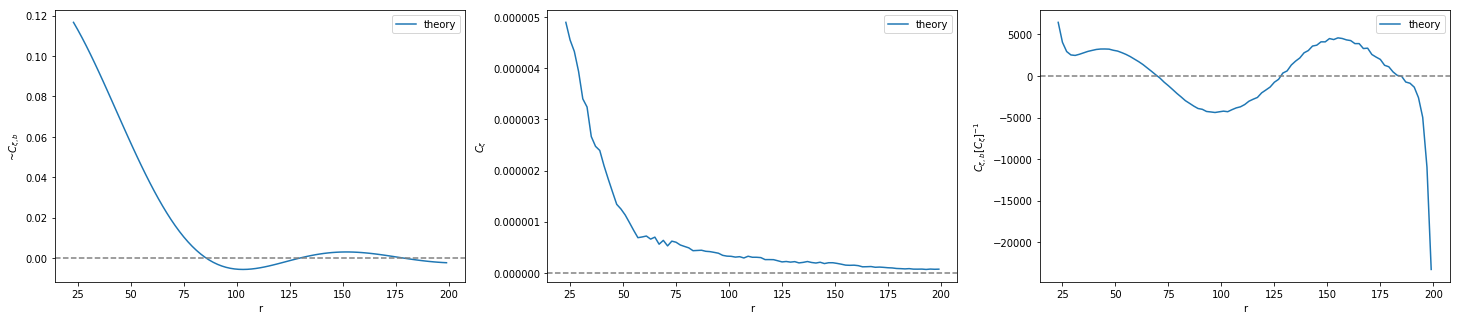

In [26]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin,Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~$C_{\xi,b}$')
ax.legend()
#ax.set_ylim(-50000,50000)



ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
#ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='mock x 5000')
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

In [27]:
fig, ax = plt.subplots()
ax.plot( kbin,Cpb)
ax.plot( kbin,mock_covbp[:,idx_kmin:idx_kmax].ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'~$C_{p,b}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin,mock_covp[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
ax.plot( kbin,covp_model[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(k'$C_{p}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin, final_p)
ax.plot( kbin, final_mock_p.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'$C_{p,b} [C_{p}]^{-1}$')
#ax.set_ylim(-50000,50000)

SyntaxError: invalid syntax (<ipython-input-27-9cb2aefddbd9>, line 19)